## Case Study: Bike Sharing Program In Chicago 

Capstone project for the Google Data Analytics Professional Certificate program. The program prepares participants for a career in data analytics.

### About the company 

Cyclistic lauched a bike-share program in 2016, Chicago.It has since grown to a fleet of 5,824 bicycles that are geo-tracked and locked into a network of 692 stations across Chicago. The bikes can be unlocked from one station and returned to any other station in the system anytime.



* Causual riders: customers who purchase single-ride or full-day passes.

* Members: customers who purchase annual memberships 

Objective: Find out how do annual members and casual riders use Cyclistic bikes differently in order to faciliate the marketing strategies that aim to convert casual riders to members.


### Data Description
**About the Dataset**

* Data are made available by Motivate International Inc. under this [license](https://www.divvybikes.com/data-license-agreement). Entire historical data can be accessed [here](https://divvy-tripdata.s3.amazonaws.com/index.html).
* The data set does not include riders' personally-identifiable information. So we won't know if casual riders have purchased multiple single passes or if they live in the Cyclistic service area.



**The Data**


Each trip is anonymized and includes:

- Unique Ride Trip ID `ride_id`
- Bike Type (Classic Bike, Electric Bike, Docked Bike)`rideable_type`
- Trip start day and time `started_at`
- Trip end day and time `ended_at`
- Trip start station `start_station_name` `start_station_id` `start_lat` `start_lng`
- Trip end station `end_station_name` `end_station_id` `end_lat` `end_lng`
- Rider type (Member, Single Ride, and Day Pass) `member_casual`
- Ride Length `ride_length`



The data has been processed to remove trips that are taken by staff as they service and inspect the system; and any trips that were below 60 seconds in length (potentially false starts or users trying to re-dock a bike to ensure it was secure). 

### Summary of Findings 

- Member users uses the bike share system for commuting purposes. The average ride length is around 10-15 minutes. 
- A subset of casual riders uses the bike share system as a daily commuter.
- Unlike member users, casual-user commuters has a longer average ride length, around 22-25 minutes using classic bikes, and around 15 minutes using electric bikes.

### Key Insight

Casual users include both tourists and residents, as suggested by higher weekend ride numbers indicating leisure activities. However, their weekday usage patterns resemble those of members who primarily commute. For casual users, average ride times are about 40 minutes for classic bikes and 15 minutes for electric bikes during weekday rush hours. Given this, I propose experimenting with an electric bike membership targeted at casual users to encourage their conversion to member users.



In [4]:
import requests
import zipfile
import io


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns   

# set plot style
sns.set(style="darkgrid")

# Set global figure parameters
plt.rc(
    "figure",
    autolayout=True,
    titlesize=18,
    titleweight='bold',
)

# Set global axes parameters

plt.rc(
    "axes",
    labelweight="bold",
    labelsize="small",
    titleweight="bold",
    titlesize=12,
    titlepad=5,
)

# Set global legend parameters
plt.rc('legend', frameon=False)  # Turn off the frame around the legend


In [7]:
# Read the file 'divvy_trips_2020_2023.feather'
data = pd.read_feather('divvy_trips_2020_2023.feather')

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16231413 entries, 3214075 to 20169097
Data columns (total 14 columns):
 #   Column              Dtype         
---  ------              -----         
 0   ride_id             object        
 1   rideable_type       category      
 2   started_at          datetime64[ns]
 3   ended_at            datetime64[ns]
 4   start_station_name  object        
 5   start_station_id    object        
 6   end_station_name    object        
 7   end_station_id      object        
 8   start_lat           float64       
 9   start_lng           float64       
 10  end_lat             float64       
 11  end_lng             float64       
 12  member_casual       category      
 13  ride_length         float64       
dtypes: category(2), datetime64[ns](2), float64(5), object(5)
memory usage: 1.6+ GB


### Descriptive Analysis

In [12]:
# Make a pivot table of the number of rides in each year, broken down by ride type
pivot = data.pivot_table(
    index=data.started_at.dt.year,
    columns=['member_casual'],
    values='ride_length',
    aggfunc=['size', 'mean'],
)

pivot_size = pivot['size']
pivot_size_pct_change = pivot_size.pct_change().fillna(0) * 100
pivot = pd.concat([pivot, pivot_size_pct_change.add_suffix('_pct_change')], axis=1)

pivot

,"(size, casual)","(size, member)","(mean, casual)","(mean, member)",casual_pct_change,member_pct_change
started_at,,,,,,
2020,1280408,2051404,48.582288,15.853929,0.000000,0.000000
2021,2027688,2500603,32.835992,13.384355,58.362647,21.897149
2022,1730953,2561008,24.363127,12.687329,-14.634155,2.415617
2023,1468869,2610480,23.497996,12.462532,-15.141023,1.931739


Causal users grew significantly in 2021 (58% YoY growth), member users also saw fast growth ( 21% YoY). 

Casual users growth dropped in 2022 and 2023 potentially due to Covid-19 lockdown (less tourists in chicago). Member users growth are not affected as much during the same period - with 2.4% growth in 2022 and 1.93% growth in 2023.

Cansual users on average has 25 minutes ride while member users on average has 12 minutes ride.

In [26]:
## I will use 2022 data to explore the different ride types to avoid the pandemic effect
## Chicage lifted lockdown in 2021 June, assuming 2022 data will reflect the normal trend of the bike rides
# Extract data excluding the year 2022
df = data.loc[data.started_at.dt.year == 2022].copy()

Text(0.5, 1.0, 'Ride Length by User Type')

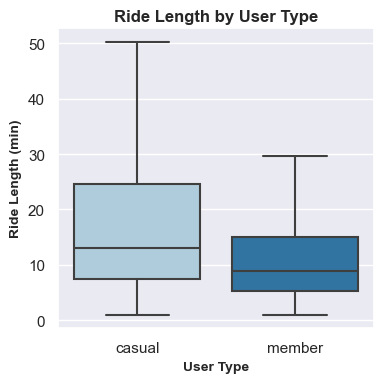

In [27]:
# plot box plot on ride_length in minutes for both causal and member users
plt.figure(figsize=(4, 4))
sns.boxplot(data=df, x='member_casual', y='ride_length', showfliers=False)
plt.ylabel('Ride Length (min)')
plt.xlabel('User Type')
plt.title('Ride Length by User Type')

#### Monthly Pattern: Causal VS Member

Text(0.5, 0.98, 'Rides by Month and User Type')

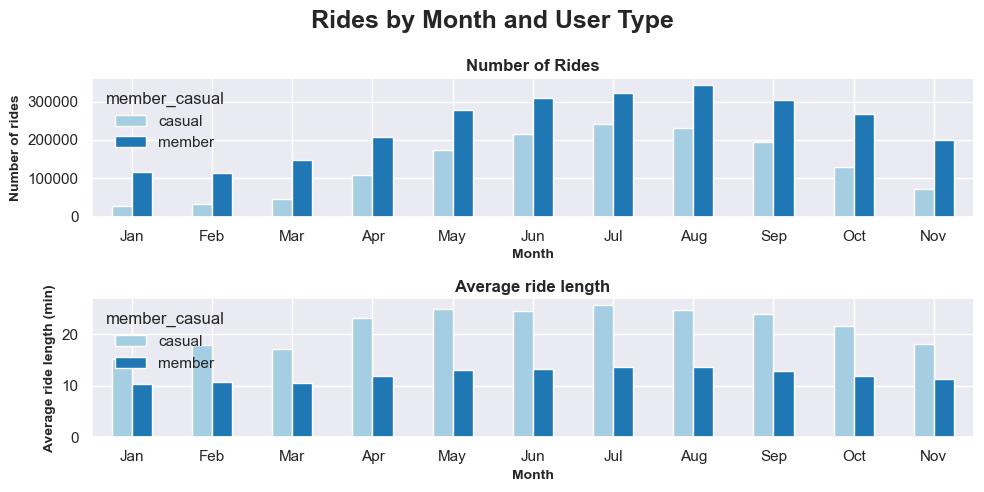

In [29]:
# Create a pivot table of the number of rides by month and ride type

pivot_num_of_rides = df.pivot_table(
    index=df.started_at.dt.month,
    columns='member_casual',
    values='ride_id',
    aggfunc='size',
)

# Find the average ride_length for each user type in each month
pivot_ave_ride_length = df.pivot_table(
    index=df.started_at.dt.month,
    columns='member_casual',
    values='ride_length',
    aggfunc='mean',
)

# Change the month number to month abbreviation
pivot_num_of_rides.index = pd.to_datetime(pivot_num_of_rides.index, format='%m').strftime('%b')
pivot_ave_ride_length.index = pd.to_datetime(pivot_ave_ride_length.index, format='%m').strftime('%b')


fig, ax = plt.subplots(2, 1, figsize=(10, 5))
pivot_num_of_rides.plot(kind='bar', rot=0, xlabel="Month", ylabel= "Number of rides", title='Number of Rides', ax=ax[0])
pivot_ave_ride_length.plot(kind='bar', rot=0, xlabel="Month", ylabel= "Average ride length (min)", title='Average ride length', ax=ax[1])

# Set title for the plot
fig.suptitle('Rides by Month and User Type')

**Num of Rides**
* Members have more rides than casual riders in each month. 
* The peak for both user types peak in summer, suggesting that more rides are taken during warmer months.  
* December and January shows the least ride activity, due to cold weather.


**Average ride length**
* Casual users consistently have longer ride durations than members each month.
* Member users show a more consistent pattern of ride lengths throughout the year, indicating that their usage may be more regular and possibly commute-related.


#### Daily pattern: Causal vs Memeber

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_rides_and_ride_length(df, user_type):
    # Filter data based on user type
    filtered_df = df.loc[df.member_casual == user_type]
    
    # Create pivot tables
    pivot_num_of_ride = filtered_df.pivot_table(
        index=filtered_df.started_at.dt.dayofweek,
        columns=filtered_df.started_at.dt.hour,
        values='ride_id',
        aggfunc='size',
    )

    pivot_ave_ride_length = filtered_df.pivot_table(
        index=filtered_df.started_at.dt.dayofweek,
        columns=filtered_df.started_at.dt.hour,
        values='ride_length',
        aggfunc='mean',
    )
    
    # Set the color palette to discrete colors
    sns.set_palette('Paired', 12)
    
    fig, ax = plt.subplots(nrows=2, figsize=(20, 15))
    
    # Change the index to day of week abbreviations
    pivot_num_of_ride.index = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    pivot_ave_ride_length.index = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    
    # Change the column names to hour of the day
    pivot_num_of_ride.columns = [f'{hour}:00' for hour in pivot_num_of_ride.columns]
    pivot_ave_ride_length.columns = [f'{hour}:00' for hour in pivot_ave_ride_length.columns]
    
    # Plot the number of rides
    pivot_num_of_ride.plot(kind='bar', rot=0, figsize=(15, 8), xlabel="", ylabel="Number of rides", title='Number of Rides', ax=ax[0])
    
    # Plot the average ride length
    pivot_ave_ride_length.plot(kind='bar', rot=0, figsize=(15, 5), xlabel="", ylabel="Average Ride Length (min)", title='Average Ride Length', ax=ax[1])
    
    # Remove ax[0] legend
    ax[0].legend([], [], frameon=False)
    
    # Put legend at the bottom horizontally
    ax[1].legend(loc='lower center', ncol=12, bbox_to_anchor=(0.5, -0.7))
    
    # Set title for the fig
    fig.suptitle(f'{user_type.capitalize()} Users')
    
    plt.show()


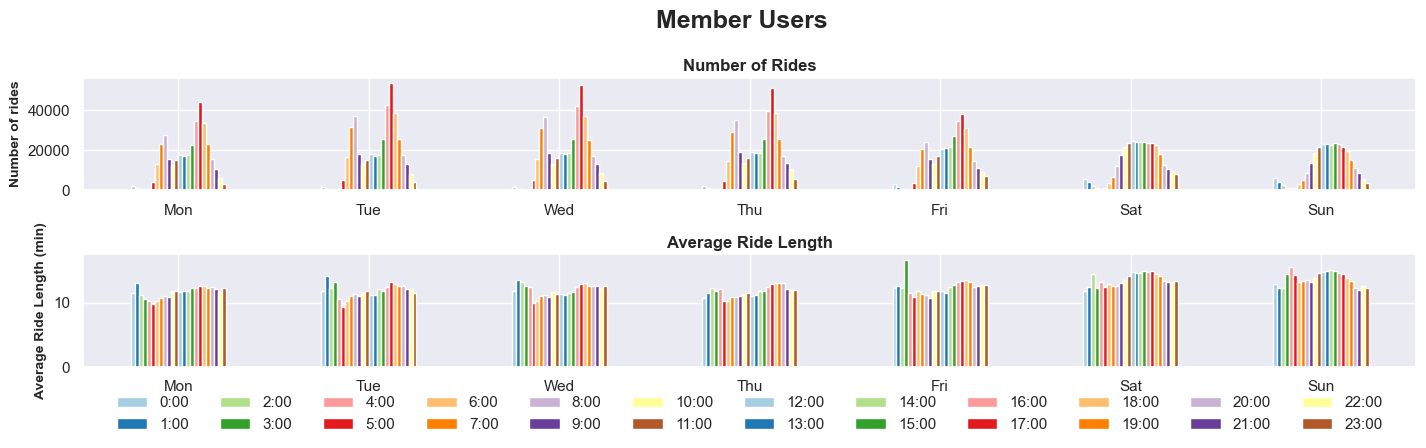

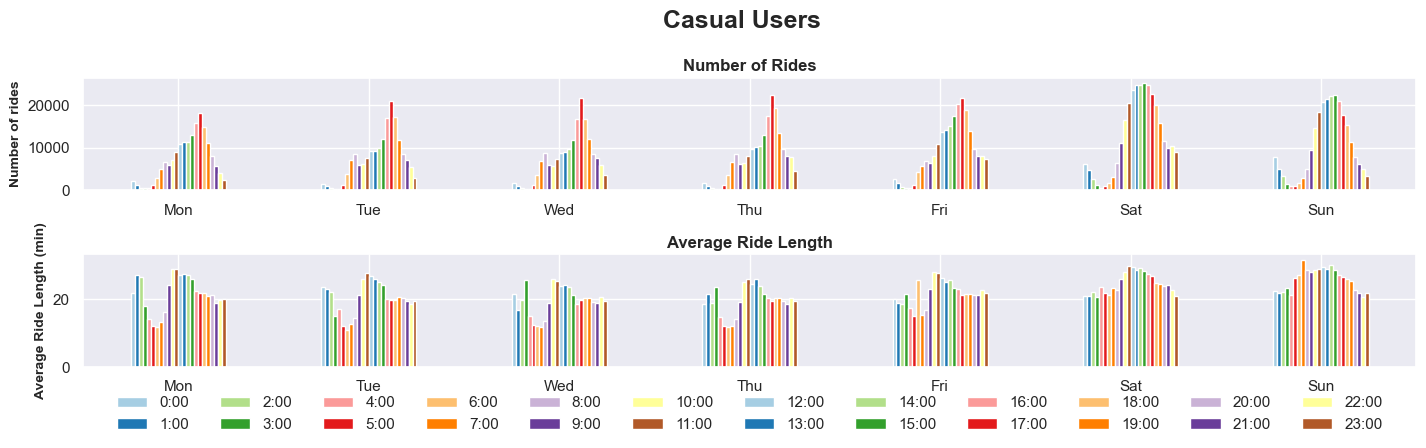

In [32]:
plot_rides_and_ride_length(df, 'member')
plot_rides_and_ride_length(df, 'casual')

**Member users**
* Number of riders is the highest from 4pm-6pm during week days, following by 4-8am, suggesting that members are likely to use bikes for commuting purposes. 
* Average ride length is consistent across each day of week, ranging from 10-15 minutes. 

**Casual Users**
* Casual users also see a peak around 4pm - 6pm during the week days, potentially are commuters who do not have a membership. But unlike member users, casual rides do not see a spike from 6-8am like member rides do. I hypothsize that a portion of casual users bikes for commuting purposes but unlike members users who bikes for commuting, they live farther from work/school.

* The average ride length for casual users are around 20-25 minutes at 4-6pm during the week days. 


#### Identity Member vs Casual users' usage patterns during 4-6pm Weekdays

In [33]:
# Find the average and size of rides by day of the week and by rideable_type
df_member_4_6pm = df.loc[(df.member_casual == 'member') &  (df.started_at.dt.dayofweek < 5) & (df.started_at.dt.hour >= 16) & (df.started_at.dt.hour <= 18)].copy()
pivot_ave_ride_length_member_4_6pm = df_member_4_6pm.pivot_table(
    index=df_member_4_6pm.started_at.dt.dayofweek,
    columns='rideable_type',
    values='ride_length',
    aggfunc=['mean', 'size'],
)

# Change the index to day of week abbreviations
pivot_ave_ride_length_member_4_6pm.index = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri']

pivot_ave_ride_length_member_4_6pm

mean                       size              \
rideable_type classic_bike electric_bike classic_bike docked_bike   
Mon              13.245067     10.951407        73576           0   
Tue              13.644822     11.440323        88289           0   
Wed              13.536771     11.374326        85602           0   
Thu              13.403496     11.671854        83675           0   
Fri              14.074162     11.913332        67880           0   

                             
rideable_type electric_bike  
Mon                   38559  
Tue                   46438  
Wed                   46639  
Thu                   45678  
Fri                   36068

In [34]:
# Make a subset of casual users who uses the bike from 4-6pm on weekdays
df_casual_4_6pm = df.loc[(df.member_casual == 'casual') & (df.started_at.dt.dayofweek < 5) & (df.started_at.dt.hour >= 16) & (df.started_at.dt.hour < 18)].copy()

# Find the average and size of rides by day of the week and by rideable_type
pivot_ave_ride_length_casual_4_6pm = df_casual_4_6pm.pivot_table(
    index=df_casual_4_6pm.started_at.dt.dayofweek,
    columns='rideable_type',
    values='ride_length',
    aggfunc=['mean', 'size'],
)

# Change the index to day of week abbreviations
pivot_ave_ride_length_casual_4_6pm.index = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri']

pivot_ave_ride_length_casual_4_6pm

mean                                   size              \
rideable_type classic_bike docked_bike electric_bike classic_bike docked_bike   
Mon              25.184797   53.531584     14.513148        18318        1582   
Tue              22.214516   51.985219     13.707890        20192        1609   
Wed              22.420331   48.237451     13.354480        19834        1437   
Thu              22.507105   48.940082     13.986431        20761        1593   
Fri              24.674624   50.826024     14.922084        23393        2068   

                             
rideable_type electric_bike  
Mon                   13874  
Tue                   16201  
Wed                   17210  
Thu                   17543  
Fri                   16528

In [35]:
top_10_stations_member = df_member_4_6pm.groupby('start_station_name')['ride_id'].count().sort_values(ascending=False).head(20)

# Join the latitudes and longitudes of the top 10 stations to top_10_stations_member
top_10_stations_member = top_10_stations_member.to_frame().join(df_member_4_6pm.groupby('start_station_name')[['start_lat', 'start_lng']].mean()).reset_index()

top_10_stations_casual = df_member_4_6pm.groupby('start_station_name')['ride_id'].count().sort_values(ascending=False).head(20)

# Join the latitudes and longitudes of the top 10 stations to top_10_stations_casual
top_10_stations_casual = top_10_stations_casual.to_frame().join(df_member_4_6pm.groupby('start_station_name')[['start_lat', 'start_lng']].mean()).reset_index()


In [39]:
top_10_stations_member == top_10_stations_casual

,start_station_name,ride_id,start_lat,start_lng
0,True,True,True,True
1,True,True,True,True
2,True,True,True,True
3,True,True,True,True
4,True,True,True,True
5,True,True,True,True
6,True,True,True,True
7,True,True,True,True
8,True,True,True,True
9,True,True,True,True


In [40]:
# Top 10 ending stations
top_10_stations_member_end = df_member_4_6pm.groupby('end_station_name')['ride_id'].count().sort_values(ascending=False).head(20)

# Join the latitudes and longitudes of the top 10 stations to top_10_stations_member
top_10_stations_member_end = top_10_stations_member_end.to_frame().join(df_member_4_6pm.groupby('end_station_name')[['end_lat', 'end_lng']].mean()).reset_index()

# Top 10 ending stations
top_10_stations_casual_end = df_casual_4_6pm.groupby('end_station_name')['ride_id'].count().sort_values(ascending=False).head(20)

# Join the latitudes and longitudes of the top 10 stations to top_10_stations_member
top_10_stations_casual_end = top_10_stations_casual_end.to_frame().join(df_casual_4_6pm.groupby('end_station_name')[['end_lat', 'end_lng']].mean()).reset_index()


<Axes: title={'center': 'Casual Users'}, ylabel='end_station_name'>

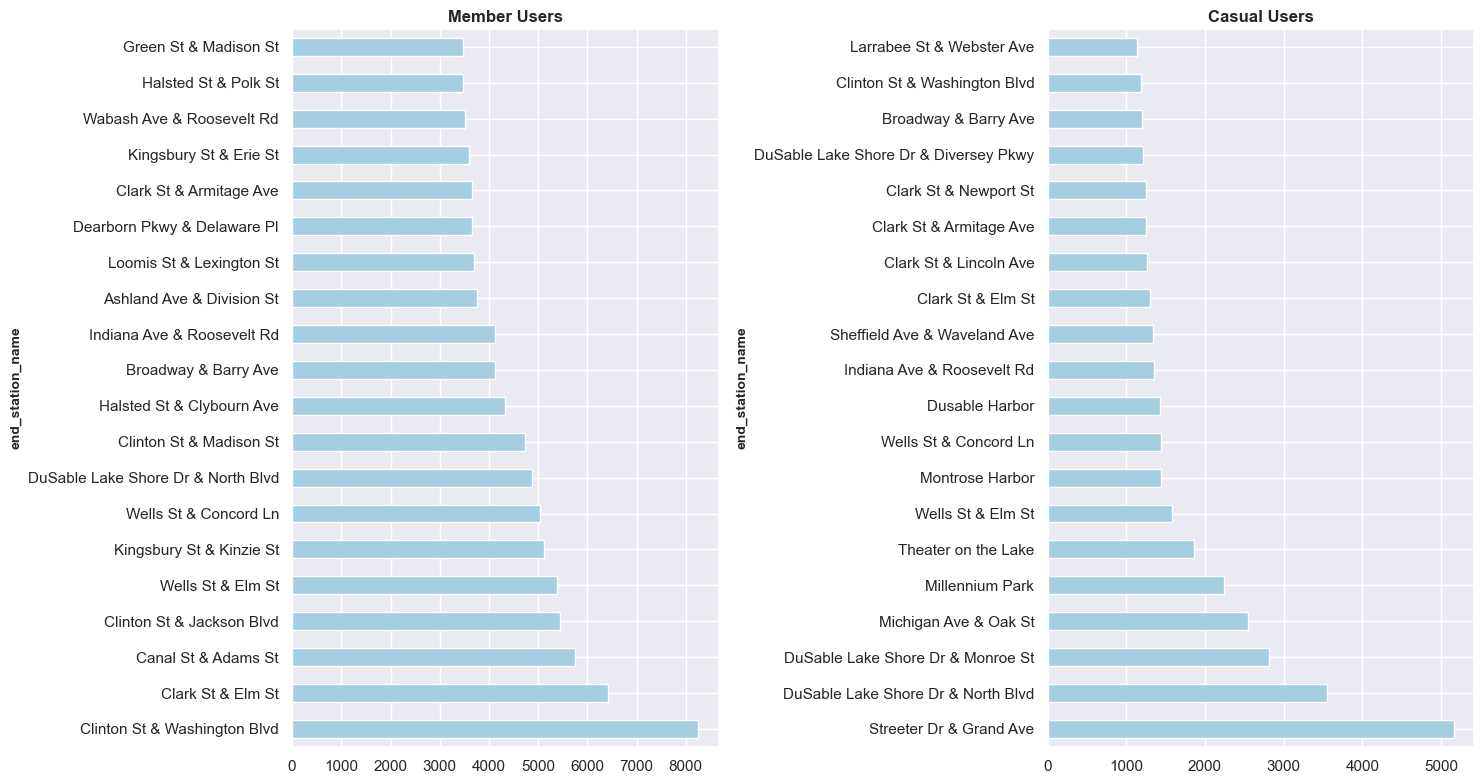

In [41]:
# make barh plot using top_10_stations_member_end and top_10_stations_casual_end

fig, ax = plt.subplots(1, 2, figsize=(15, 8))

top_10_stations_member_end.plot(kind='barh', x='end_station_name', y='ride_id', ax=ax[0], legend=False, title='Member Users')
top_10_stations_casual_end.plot(kind='barh', x='end_station_name', y='ride_id', ax=ax[1], legend=False, title='Casual Users')


In [42]:
# Visualize top 20 stations on map

import folium

# Create a map
m = folium.Map(location=[41.881832, -87.623177], zoom_start=12)

# Add markers to the map
for idx, row in top_10_stations_member.iterrows():
    folium.Marker(
        location=[row['start_lat'], row['start_lng']],
        popup=row['start_station_name'],
        icon=folium.Icon(color='blue', icon='bicycle', prefix='fa')
    ).add_to(m)

# Display the map
m

In [43]:
# Visualize top 10 end station
# Create a map

m = folium.Map(location=[41.881832, -87.623177], zoom_start=12)

# Add markers to the map

for idx, row in top_10_stations_member_end.iterrows():
    folium.Marker(
        location=[row['end_lat'], row['end_lng']],
        popup=row['end_station_name'],
        icon=folium.Icon(color='blue', icon='bicycle', prefix='fa')
    ).add_to(m)

for idx, row in top_10_stations_casual_end.iterrows():
    folium.Marker(
        location=[row['end_lat'], row['end_lng']],
        popup=row['end_station_name'],
        icon=folium.Icon(color='purple', icon='bicycle', prefix='fa')
    ).add_to(m)

# Display the map
m

* Top 20 starting station are the same for casual and member users from 4-6pm 
* Top 20 ending station are different, popular end station for member users are centered in the city, while some end station for casual users are by the lake and parks. About 6 out of 20 top end station for casual users are not by the lake.

This suggests that a majority casual riders from 4-6pm are likely to ride for leisure. Some casual riders are likely to ride for commuting purpose. To further identity the characteristics of casual riders during rush hours. I randomly draw 100 samples from df_casual_4_6pm to observe their activity. 

In [44]:
# Take a random sample of 500 rows from df_casual_4_6pm

df_casual_4_6pm_sample = df_casual_4_6pm.sample(100, random_state=42)

# Visualize the state_station and end_station of the sample on the map, connecting start and end stations with a line

m = folium.Map(location=[41.881832, -87.623177], zoom_start=12)

for idx, row in df_casual_4_6pm_sample.iterrows():
    folium.Marker(
        location=[row['start_lat'], row['start_lng']],
        popup=row['start_station_name'],
        icon=folium.Icon(color='blue', icon='bicycle', prefix='fa')
    ).add_to(m)
    
    folium.Marker(
        location=[row['end_lat'], row['end_lng']],
        popup=row['end_station_name'],
        icon=folium.Icon(color='orange', icon='bicycle', prefix='fa')
    ).add_to(m)
    
    folium.PolyLine(
        locations=[[row['start_lat'], row['start_lng']], [row['end_lat'], row['end_lng']]],
        color='blue',
        weight=2,
        opacity=0.5
    ).add_to(m)


folium.Marker(
    location=[41.881832, -87.623177],
    popup='Chicago',
    icon=folium.Icon(color='red', icon='school', prefix='fa')
).add_to(m)

folium.Marker(
    location=[41.8786, -87.6359],
    popup='University of Chicago',
    icon=folium.Icon(color='red', icon='school', prefix='fa')
).add_to(m)

folium.Marker(
    location=[41.7897, -87.5997],
    popup='Illinois Institute of Technology',
    icon=folium.Icon(color='red', icon='school', prefix='fa')
).add_to(m)

folium.Marker(
    location=[41.9803, -87.6685],
    popup='Loyola University Chicago',
    icon=folium.Icon(color='red', icon='school', prefix='fa')
).add_to(m)

folium.Marker(

    location=[41.9245, -87.6493],

    popup='DePaul University',

    icon=folium.Icon(color='red', icon='school', prefix='fa')

).add_to(m)

folium.Marker(
        location=[41.9759, -87.669],
        popup='Northwestern University',
        icon=folium.Icon(color='red', icon='school', prefix='fa')
    
    ).add_to(m)


# Display the map
m

 Some end station of casual users are in residential areas. Therefore, we can infer that they uses the bike share system for commuting purposes. For example, one ride starts at a fitness center and ends up at a residential building. There is another ride that starts at a residential building and end at Amundsen high school. 

### Appendix (Data Extraction & Preprocessing)

In [ ]:
# def get_data(year_range, month_or_quarter):
#     combined_data = []

#     for year in range(year_range[0], year_range[1]):
#         for mq in month_or_quarter:
#             # Determine the URL format
#             if isinstance(mq, int):  # If it's a month
#                 zip_url = f"https://divvy-tripdata.s3.amazonaws.com/{year}{mq:02d}-divvy-tripdata.zip"
#             else:  # If it's a special identifier like 'Q1'
#                 zip_url = f"https://divvy-tripdata.s3.amazonaws.com/Divvy_Trips_{year}_{mq}.zip"
            
#             print(f"Downloading from: {zip_url}")

#             # Download the ZIP file
#             response = requests.get(zip_url)
#             if response.status_code != 200:
#                 print(f"Failed to download. Status code: {response.status_code}")
#                 continue

#             try:
#                 zip_file = zipfile.ZipFile(io.BytesIO(response.content))
#             except zipfile.BadZipFile:
#                 print("Downloaded file is not a valid ZIP file.")
#                 continue

#             # Extract the ZIP file
#             zip_file.extractall("divvy_tripdata")

#             # Load CSV into a DataFrame
#             csv_filename = zip_file.namelist()[0]
#             data = pd.read_csv(f"divvy_tripdata/{csv_filename}")

#             # Add the data to the combined list
#             combined_data.append(data)

#     # Combine all dataframes into one
#     if combined_data:
#         combined_dataframe = pd.concat(combined_data, ignore_index=True)
#         return combined_dataframe
#     else:
#         print("No data downloaded.")
#         return None
    
# try:
#     year_range = (2020, 2024)  # Range of years
#     months_and_quarters = list(range(1, 13))  # Creating a list of months
#     months_and_quarters.extend(['Q1', 'Q2', 'Q3', 'Q4'])  # Adding quarters to the list
    
#     combined_dataframe = get_data(year_range, months_and_quarters)  # Passing the correct variable
#     if combined_dataframe is not None:
#         print(combined_dataframe.head())
# except Exception as e:
#     print(str(e))



In [ ]:
# # sort the dataframe by started_at ascending
# combined_dataframe = combined_dataframe.sort_values(by='started_at', ascending=True)

# # Convert 'started_at' and 'ended_at' to datetime
# combined_dataframe[['started_at', 'ended_at']] = combined_dataframe[['started_at', 'ended_at']].apply(pd.to_datetime)

# # Format the datetime objects to keep only up to seconds
# combined_dataframe['started_at'] = combined_dataframe['started_at'].dt.strftime('%Y-%m-%d %H:%M:%S')
# combined_dataframe['ended_at'] = combined_dataframe['ended_at'].dt.strftime('%Y-%m-%d %H:%M:%S')

# # Convert them back to datetime objects
# combined_dataframe[['started_at', 'ended_at']] = combined_dataframe[['started_at', 'ended_at']].apply(pd.to_datetime)

# # Convert categorical columns
# combined_dataframe[['rideable_type', 'member_casual']] = combined_dataframe[['rideable_type', 'member_casual']].astype('category')

# # Convert string columns
# combined_dataframe[['ride_id', 'start_station_name', 'end_station_name',  'start_station_id', 'end_station_id']] = combined_dataframe[['ride_id', 'start_station_name', 'end_station_name',  'start_station_id', 'end_station_id']].astype('str')

In [ ]:
# print(f"Number of rows: {combined_dataframe.shape[0]:,}")
# print("Number of unique rides:", combined_dataframe.ride_id.nunique())
# # There are more rows than unique rides, so some rides must have multiple rows.


In [ ]:
# # Use list comprehension to calculate the duration of each ride
# combined_dataframe['ride_length'] = [end - start for start, end in zip(combined_dataframe.started_at, combined_dataframe.ended_at)]

# # Convert duration to minutes
# combined_dataframe['ride_length'] = combined_dataframe['ride_length'].dt.total_seconds() / 60

In [ ]:
# # Return duplicate ride_id rows 
# combined_dataframe[combined_dataframe.duplicated(subset='ride_id')].head()

# # By investigating the data, we can see that the duration is off for the duplicate rows.

In [ ]:
# # Remove duplicated rows
# combined_dataframe = combined_dataframe.drop_duplicates(subset='ride_id')

# # Replace nan with numpy.nan
# combined_dataframe = combined_dataframe.replace({'nan': np.nan})

# # drop rows with nan values
# combined_dataframe = combined_dataframe.dropna()

# # Remove rows with duration less than 1 minute
# combined_dataframe = combined_dataframe[combined_dataframe['ride_length'] > 1]

# # Save the dataframe to a feather file. Note that feather files are accessed by Python, R, and Julia
# feather.write_feather(combined_dataframe, 'divvy_trips_2020_2023.feather')